In [1]:
##### setting up the environment
from datetime import date, datetime, timedelta
import os
from typing import Literal
import time
import re
import pandas as pd
import numpy as np
import json
import requests
from dotenv import load_dotenv
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima 
import seaborn as sns
from tabulate import tabulate
import math
import warnings
from scipy import stats


# Set up the data

In [2]:
BUCKET = '/mnt/dsa/home/gpchow/inflationpers/dataframe/'

# headline inflation (monthly frequency)
headline_inflation_df = pd.read_parquet(BUCKET + "inflation-headline.parquet")

# headline inflation by country (monthly frequency)
headline_inflation_country = pd.read_parquet(BUCKET + "inflation-other-country.parquet")
headline_inflation_country = pd.merge(headline_inflation_country, headline_inflation_df, left_index = True, right_index = True)
headline_inflation_country.rename(columns = {'cpi_month': 'malaysia'}, inplace = True)

In [3]:
start_date = pd.to_datetime('1972-01-01')

# Comparison with other countries
## Analysis using full sample

In [4]:
def modeling(input, country, num_lags, output_choice):
    # create the lagged variable dataframe
    X = pd.DataFrame(index=input.index)

    for lag in range(1, num_lags + 1):
        X[f'{country}_lag{lag}'] = input[country].shift(lag)

    # Add constant term to X
    X = sm.add_constant(X)

    inflation_df_month_full = input[country].loc[start_date:,]
    X_full = X.loc[start_date:,]
    
    # Fit the OLS model
    model = sm.OLS(inflation_df_month_full, X_full)
    results = model.fit()

    coef = sum(results.params[1:])
    if output_choice == 1:
        print(country, ": ", coef)
    elif output_choice == 2:
        result_df = pd.DataFrame({'country': [country], 'coefficient': [coef]})
        return result_df
    else:
        print("Invalid output choice. Please enter 1 to print the result or 2 to store it in a DataFrame.")

country_df = pd.DataFrame()
country_df['country'] = np.nan
country_df['coefficient'] = np.nan

for country in headline_inflation_country.columns:
    result_df_1 = modeling(headline_inflation_country, country, 12, 2)
    country_df = pd.concat([country_df, result_df_1], ignore_index=True)

country_df['country'] = country_df['country'].apply(lambda x: x.title())
country_df = country_df.sort_values(by='country')
country_df['coefficient'] = country_df['coefficient'].round(3)
country_df

,country,coefficient
0,Chile,0.980
1,France,0.995
2,Germany,0.973
3,Indonesia,0.965
4,Italy,0.995
12,Malaysia,0.951
5,Philippines,0.963
6,Singapore,0.944
7,Spain,0.991
8,Thailand,0.968


In [5]:
advanced_economies = ['France', 'Germany', 'Italy', 'Singapore', 'Spain', 'United Kingdom', 'United States']
country_df['classification'] = country_df['country'].apply(lambda x: 'Advanced' if x in advanced_economies else 'Emerging')
mean_result_df = country_df.groupby('classification')['coefficient'].mean().reset_index()
mean_result_df

,classification,coefficient
0,Advanced,0.9796
1,Emerging,0.9735


In [6]:
# Separate the data into two groups
group1 = country_df[country_df["classification"] == "Advanced"]["coefficient"]
group2 = country_df[country_df["classification"] == "Emerging"]["coefficient"]

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(group1, group2)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.6197271808386368
P-Value: 0.5480594745557332


In [7]:
def modeling_rolling_country(country, num_lags, window_size, start_date, rho_full):
    # create the lagged variable dataframe
    X = pd.DataFrame(index=headline_inflation_country.index)

    for lag in range(1, num_lags + 1):
        X[f'{country}_lag{lag}'] = headline_inflation_country[country].shift(lag)

    # Add constant term to X
    X = sm.add_constant(X)

    inflation_df_month_full = headline_inflation_country[country].loc[start_date:,]
    X_full = X.loc[start_date:,]
    
    models_coefficients = pd.DataFrame()  

    for i in range(window_size, len(inflation_df_month_full)):
        train_subset = inflation_df_month_full[i-window_size:i]
        X_lagged = X_full[i-window_size:i]

        # Fit the OLS model
        model = sm.OLS(train_subset, X_lagged)
        results = model.fit()
        models_coefficients[f"Model {i+1}"] = results.params
    
    rho = models_coefficients[1:].sum(axis=0)
    rho.index = inflation_df_month_full.index[window_size:]

    rho_full[country] = rho
    return rho_full

rolling_rho_country = pd.DataFrame(columns=headline_inflation_country.columns)

for country in headline_inflation_country.columns:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        modeling_rolling_country(country, 12, 168, start_date, rolling_rho_country)


### graph

In [8]:
country_before_mean = rolling_rho_country[:'2008-12-01'].mean().round(3)
country_before_mean.name = 'mean_before'
country_before_mean = pd.DataFrame(country_before_mean)
country_before_mean.reset_index(inplace = True)
country_before_mean.rename(columns = {'index':'country'}, inplace = True)
country_before_mean['country'] = country_before_mean['country'].str.title()

country_between_mean = rolling_rho_country['2009-01-01':'2020-02-01'].mean().round(3)
country_between_mean.name = 'mean_between'
country_between_mean = pd.DataFrame(country_between_mean)
country_between_mean.reset_index(inplace = True)
country_between_mean.rename(columns = {'index':'country'}, inplace = True)
country_between_mean['country'] = country_between_mean['country'].str.title()

country_after_mean = rolling_rho_country['2020-03-01':].mean().round(3)
country_after_mean.name = 'mean_after'
country_after_mean = pd.DataFrame(country_after_mean)
country_after_mean.reset_index(inplace = True)
country_after_mean.rename(columns = {'index':'country'}, inplace = True)
country_after_mean['country'] = country_after_mean['country'].str.title()

country_df = pd.merge(country_df, country_before_mean, on='country')
country_df = pd.merge(country_df, country_between_mean, on='country').drop(columns = 'classification')
country_df = pd.merge(country_df, country_after_mean, on='country')
country_df['country'] = country_df['country'].apply(lambda x: x.title())
country_df = country_df.sort_values(by='country')
country_df

,country,coefficient,mean_before,mean_between,mean_after
0,Chile,0.980,0.968,0.921,0.925
1,France,0.995,0.965,0.860,0.933
2,Germany,0.973,0.959,0.802,0.879
3,Indonesia,0.965,0.937,0.914,0.936
4,Italy,0.995,0.985,0.934,0.958
5,Malaysia,0.951,0.942,0.837,0.854
6,Philippines,0.963,0.943,0.937,0.948
7,Singapore,0.944,0.933,0.906,0.927
8,Spain,0.991,0.971,0.921,0.929
9,Thailand,0.968,0.942,0.918,0.908


### graph

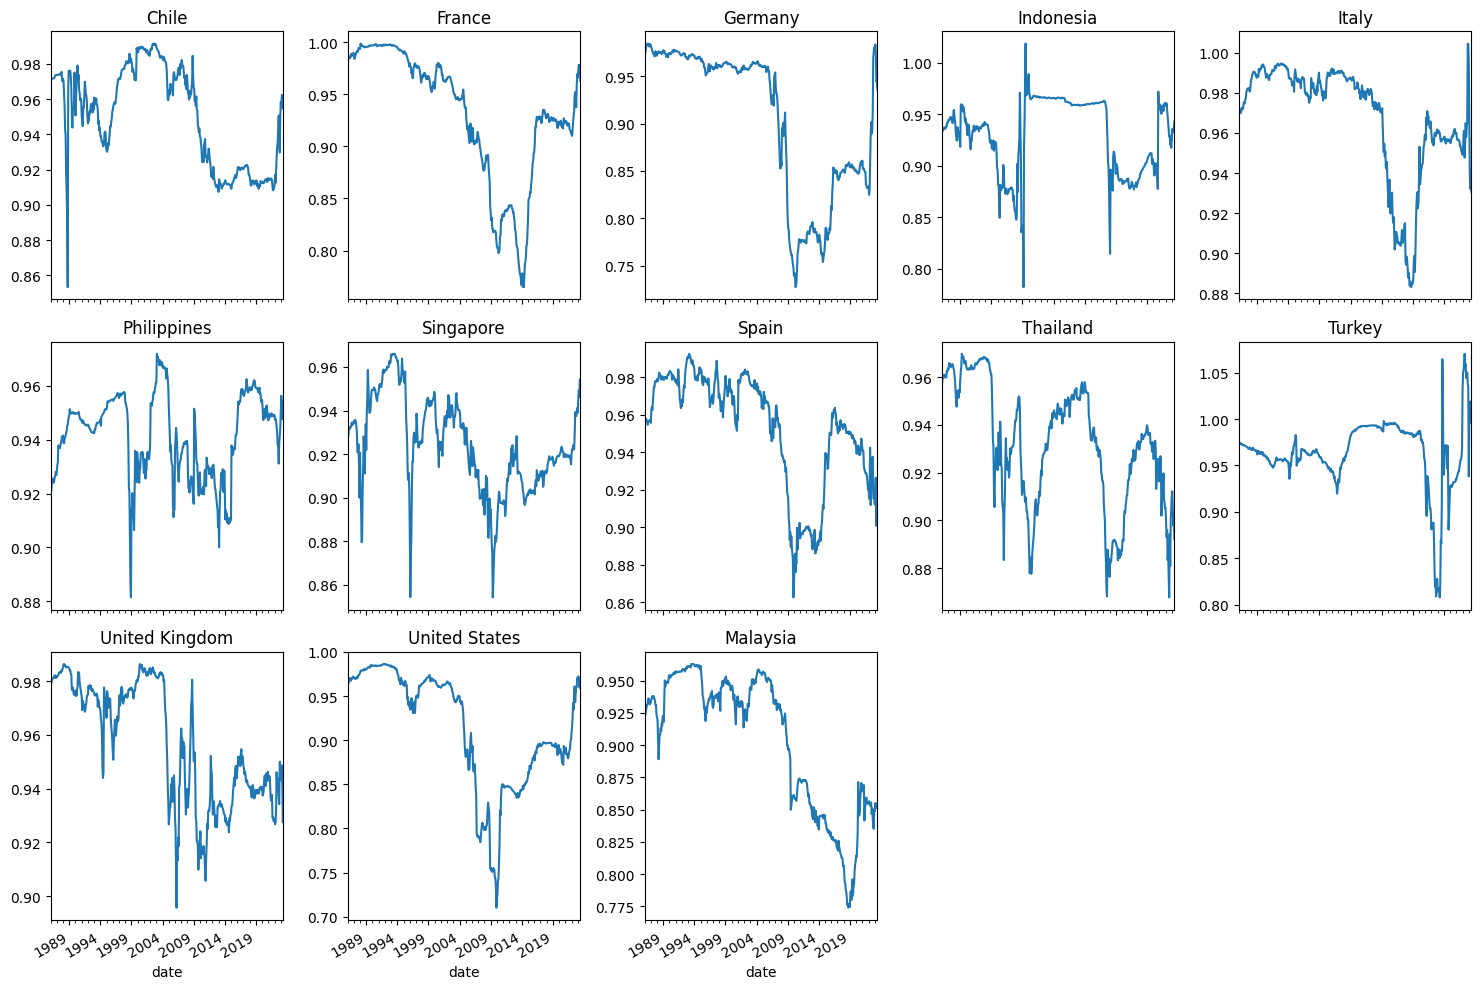

In [9]:
# Calculate the number of subplots based on the number of columns
num_columns = len(rolling_rho_country.columns)
num_subplots = min(5 * 3, num_columns)  # Ensure the number of subplots doesn't exceed the number of columns

# Create the subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

# Flatten the axes array to easily loop through each subplot
axes = axes.flatten()

# Loop through each subplot and plot the horizontal line at y=0.5
for i, ax in enumerate(axes):
    if i < num_subplots:
        # Get the column name corresponding to this subplot
        col_name = rolling_rho_country.columns[i]

        # Plot the DataFrame subplot
        rolling_rho_country[col_name].plot(ax=ax)

        # Set the subplot title to the column name
        ax.set_title(col_name.replace("_"," ").title())

        fig.autofmt_xdate()
    else:
        # If there are more subplots than columns, remove the empty subplot
        fig.delaxes(ax)

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

### correlation between rolling mean and persistence

In [10]:
rolling_mean = headline_inflation_country[start_date:].rolling(window=168).mean()

In [11]:
import scipy.stats as stats 

pearson_corr_sci = pd.DataFrame()
pearson_pvalue_sci = pd.DataFrame()

for country in rolling_rho_country.columns:
    pearson = stats.pearsonr(rolling_mean.loc[rolling_rho_country.index[0]:, country], rolling_rho_country[country])

    # Create a new DataFrame for the correlation coefficient and p-value
    corr_df = pd.DataFrame({country: [pearson[0].round(3)]})
    pvalue_df = pd.DataFrame({country: [pearson[1].round(3)]})
    
    # Concatenate the new DataFrame to the existing pearson_corr_sci and pearson_pvalue_sci DataFrames
    pearson_corr_sci = pd.concat([pearson_corr_sci, corr_df], axis=1)
    pearson_pvalue_sci = pd.concat([pearson_pvalue_sci, pvalue_df], axis=1)

pearson_corr1 = pd.concat([pearson_corr_sci, pearson_pvalue_sci], ignore_index=True)
pearson_corr1 = pearson_corr1.T
pearson_corr1.reset_index(inplace = True)
pearson_corr1.rename(columns = {0:'correlation', 1:'p-value', 'index': 'country'}, inplace = True)
pearson_corr1['country'] = pearson_corr1['country'].apply(lambda x: x.title())
pearson_corr1 = pearson_corr1.sort_values('correlation')

pearson_corr1

,country,correlation,p-value
5,Philippines,0.114,0.015
9,Turkey,0.154,0.001
0,Chile,0.276,0.000
6,Singapore,0.342,0.000
4,Italy,0.520,0.000
7,Spain,0.553,0.000
12,Malaysia,0.577,0.000
3,Indonesia,0.584,0.000
8,Thailand,0.623,0.000
1,France,0.628,0.000
